# Galactic Dynamo

This project is a part of the term project given in course P464 Plamsa Physics and Magnetohydrodynamics taught in Spring 2024 at NISER Bhubaneswar.

Submitted by: Chandan Kumar Sahu, Integrated MSc. SPS batch 19

Supervised by: Dr. Luke R. Chamandy, SPS, NISER



### Task - 1
### Galactic Dynamo in the z-direction

We have the mean-field induction equation as 
$$ \dfrac{\partial \bar{B}}{\partial t} = \nabla \times \left[ \bar{V} \times \bar{B} + \mathcal{E} - \eta \left( \nabla \times \bar{B} \right) \right] $$
where $\mathcal{E} = \left( \alpha \bar{B} \right) - \eta_t \left( \nabla \times \bar{B} \right)$

We will solve the equations in the cylindrical coordinates (r, $\phi$, z) with the origin at the galactic centre and the z-axis parallel to the galactic angular velocity. However, to simplify things, lets make some approximations.

1. Omit the terms involving $\bar{V} \times \bar{B}$ and $\alpha$. We will land up on just the diffusion equation.
$$ \dfrac{\partial \bar{B}}{\partial t} = - \nabla \times \left[ \eta_T \left( \nabla \times \bar{B} \right) \right] $$
where $\eta_T = \eta + \eta_t$

2. Take $\eta_T$ independent of $\bar{B}$. Our equation becomes
$$ \dfrac{\partial \bar{B}}{\partial t} = - \eta_T \left[ \nabla \times \left( \nabla \times \bar{B} \right) \right] $$
But $\nabla \times \left( \nabla \times \bar{B} \right) = \nabla \left( \nabla \cdot \bar{B} \right) - \nabla^2 \bar{B} $ and $\nabla \cdot \bar{B} = 0$ (Gauss's Law), so we finally have
$$ \boxed{ \dfrac{\partial \bar{B}}{\partial t} = \eta_T \nabla^2 \bar{B} }$$

This is the Fickian diffusion equation. We will solve this equation numerically.


In cylindrical coordinates, the laplacian operator becomes

$$ \nabla^2 = \frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial}{\partial r}\right) + \frac{1}{r^2} \frac{\partial^2}{\partial \phi^2} + \frac{\partial^2}{\partial z^2} $$

So we get the final equations as
$$ \begin{aligned}
    \frac{\partial \bar{B}_r}{\partial t} &= \eta_T \frac{1}{r} \frac{\partial}{\partial r}\left(r \frac{\partial \bar{B_r}}{\partial r}\right) \\
    \frac{\partial \bar{B}_\phi}{\partial t} &= \eta_T \frac{1}{r^2} \frac{\partial^2 \bar{B}_\phi}{\partial \phi^2} \\
    \frac{\partial \bar{B}_z}{\partial t} &= \eta_T \frac{\partial^2 \bar{B}_z}{\partial z^2}
\end{aligned} $$

Since the problem statement in the project aims to solve only in the z-direction, we remove all radial or azimuthal variations of the magnetic field $\left(\dfrac{\partial }{\partial r} = \dfrac{\partial }{\partial \phi} = 0 \right)$. 

We are now left with one single equation to solve, i.e., the Fickian diffusion equation in $B_z$.
$$ \boxed{ \frac{\partial \bar{B}_z}{\partial t} = \eta_T \frac{\partial^2 \bar{B}_z}{\partial z^2} } $$



In [23]:
# Importing required libraries
import matplotlib.pyplot as plt
import numpy as np


Let's first define the function to solve the heat diffusion equation using Crank-Nicolson method. 

We need to specify the boundary conditions first. The guiding matrices need to be defined for solving the system.
Here we have written two different boundary conditions, one for free boundaries and another for isolated boundaries. 


In [24]:
"""
Get the matrices A and B for solving the diffusion equation using Crank-Nicolson method.
This function is used for free boundary conditions.

Parameters:
- N: Number of spatial grid points
- sigma: alpha*dt/dx^2

Returns:
- A: Matrix A
- B: Matrix B
"""

def diff_matrix_free_boundary(N, sigma):
    A = [[0 for j in range(N)] for k in range(N)]
    B = [[0 for j in range(N)] for k in range(N)]

    for i in range(0, N):
        A[i][i] = 2 + 2*sigma
        B[i][i] = 2 - 2*sigma
        if i > 0:
            A[i][i-1] = -sigma
            B[i][i-1] = sigma
        if i < N-1:
            A[i][i+1] = -sigma
            B[i][i+1] = sigma

    return A, B


"""
Get the matrices A and B for solving the diffusion equation using Crank-Nicolson method.
This function is used for isolated boundary conditions.

Parameters:
- N: Number of spatial grid points
- sigma: alpha*dt/dx^2

Returns:
- A: Matrix A
- B: Matrix B
"""

def diff_matrix_isolated_boundary(N, sigma):
    diag_values = 2 + 2 * sigma
    off_diag_values = -sigma

    A = np.diag(diag_values * np.ones(N)) + np.diag(off_diag_values * np.ones(N - 1), 1) + np.diag(off_diag_values * np.ones(N - 1), -1)
    B = np.diag((2 - 2 * sigma) * np.ones(N)) + np.diag(sigma * np.ones(N - 1), 1) + np.diag(sigma * np.ones(N - 1), -1)

    # Boundary conditions
    A[0, 0] = 1 + sigma
    B[0, 0] = 1 - sigma
    A[-1, -1] = 1 + sigma
    B[-1, -1] = 1 - sigma

    return A, B

Now we define the Crank-Nicholson semi-implicit algorithm to find the solution.


In [25]:


"""
Solve 1D diffusion equation using Crank-Nicolson method.

Parameters:
- x_max: Extent of the spatial domain
- t_max: Total simulation time
- dx: Spatial step size
- dt: Time step size
- Diff: Thermal diffusivity

Returns:
- u: Temperature distribution over space and time
- x: Spatial grid
- t: Time grid
"""

def crank_nicolson_diffusion(x_max, t_max, dx, dt, Diff, init_cond, source_term, boundary):

    alpha = Diff * dt / (dx**2)

    # Spatial grid
    x = [i*dx for i in range(int(x_max/dx)+1)]
    t = [j*dt for j in range(int(t_max/dt)+1)]

    # Initialize temperature array
    Temp = np.zeros((len(x), len(t)))

    # Initial condition
    for i in range(len(x)):
        Temp[i][0] = init_cond(x[i])

    # Get the matrices for solving the matrix using crank-nicolson method
    A, B = boundary(len(x), alpha)

    A = np.array(A)
    B = np.array(B)

    for j in range(1, len(t)):
        source_vector = np.array([source_term(xi, t[j]) for xi in x])
        Temp[:, j] = np.linalg.solve(A, np.dot(B, Temp[:, j - 1]) + dt * source_vector)

    return Temp, np.array(x), np.array(t)


We now define the plotting function

In [26]:

"""
Plot the solution in both 1D and Heatmap format.

Parameters:
- time_grid: Time grid
- spatial_grid: Spatial grid
- solution: Solution of the diffusion equation

Returns:
- Makes the plots
"""

def plot_diff(time_grid, spatial_grid, solution):

    # Create 2D plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in (range(0, len(time_grid), int(len(time_grid)/5))):
        plt.plot(spatial_grid, solution[:, i], label=f'time = {time_grid[i]:.1f}')
    plt.xlabel('Thickness of the galaxy (kpc)')
    plt.ylabel(r'Magnetic Field Strength ($B_z$)')
    plt.title('Diffusion of Magnetic field in z direction')
    plt.ylim(np.min(solution)-10, np.max(solution)+10)
    plt.grid()
    plt.legend()

    # Create imshow plot
    plt.subplot(1, 2, 2)
    plt.contourf(*np.meshgrid(spatial_grid, time_grid), solution.T, 40, cmap='Spectral_r')
    plt.colorbar(label=r'Magnetic Field Strength ($B_z$)')
    plt.title('Diffusion of Magnetic field in z direction')
    plt.xlabel('Thickness of the galaxy (kpc)')
    plt.ylabel('Time')
    plt.grid()



We now define the initial condition and the necessary input parameters. 

### Case 1
Let us start with a symmetric initial condition, say a gaussian magnetic field which has a maxima at the midplane.


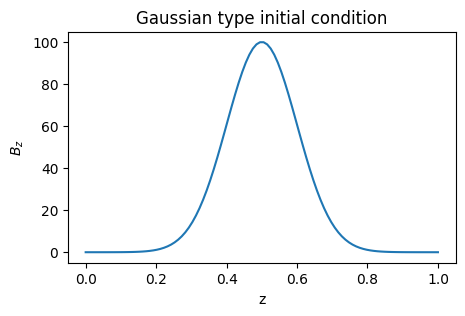

In [39]:
def init_cond(x):
    return 100*np.exp(-50*(x-0.5)**2)

plt.figure(figsize=(5, 3))
plt.plot(np.linspace(0, 1, 100), init_cond(np.linspace(0, 1, 100)))
plt.xlabel('z')
plt.ylabel(r'$B_z$')
plt.title('Gaussian type initial condition')
plt.show()

The final solution is then calculated and plotted.

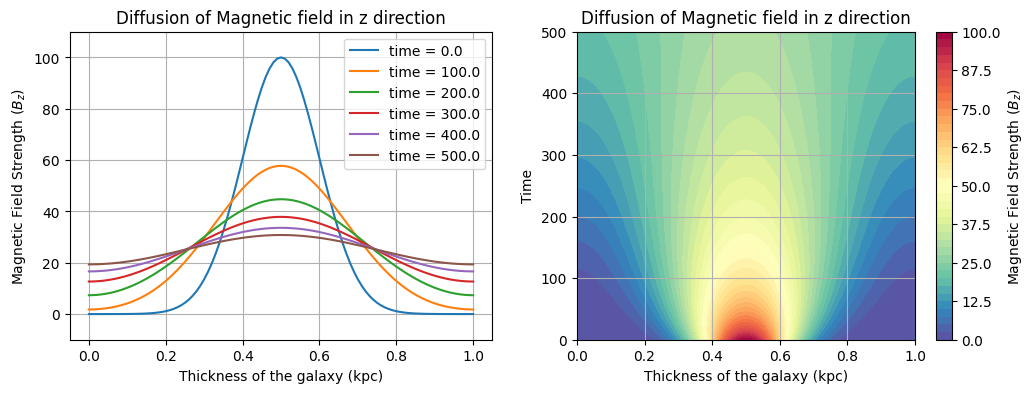

In [28]:
"""
Initial condition for the diffusion equation.

Parameters:
- x: Spatial grid

Returns:
- Initial condition
"""

def init_cond(x):
    return 100*np.exp(-50*(x-0.5)**2)



"""
Source term function.

Parameters:
- x: Spatial coordinate
- t: Time coordinate

Returns:
- Source term value at (x, t)
"""

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
eta_T = 1e-4    # magnetic diffusivity
t_max = 500     # total simulation time
z_max = 1.0     # thickness of the disc
dt = 0.05       # time step
dz = 0.01       # spatial step in z direction

solution, spatial_grid, time_grid = crank_nicolson_diffusion(z_max, t_max, dz, dt, eta_T, init_cond, source_term, diff_matrix_isolated_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution)

plt.show()


### Case - 2
Now let us start with an anti-symmetric case, where $B_z (z<0) = -B_z (z>0)$. We can use derivative of gaussian profile as shown in the figure below. Here, the magnetic field is zero at the midplane and but has positive and negative magnitudes in the upper and lower parts of the galactic disk respectively. 

Negative magnitudes correspond to reversal in the direction of the magnetic field.


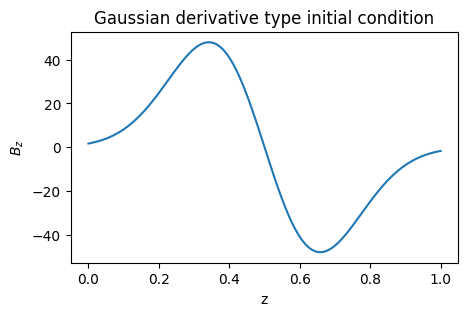

In [38]:
def init_cond(x):
    return -500*(x-0.5)*np.exp(-20*(x-0.5)**2)

plt.figure(figsize=(5, 3))
plt.plot(np.linspace(0, 1, 100), init_cond(np.linspace(0, 1, 100)))
plt.xlabel('z')
plt.ylabel(r'$B_z$')
plt.title('Gaussian derivative type initial condition')
plt.show()

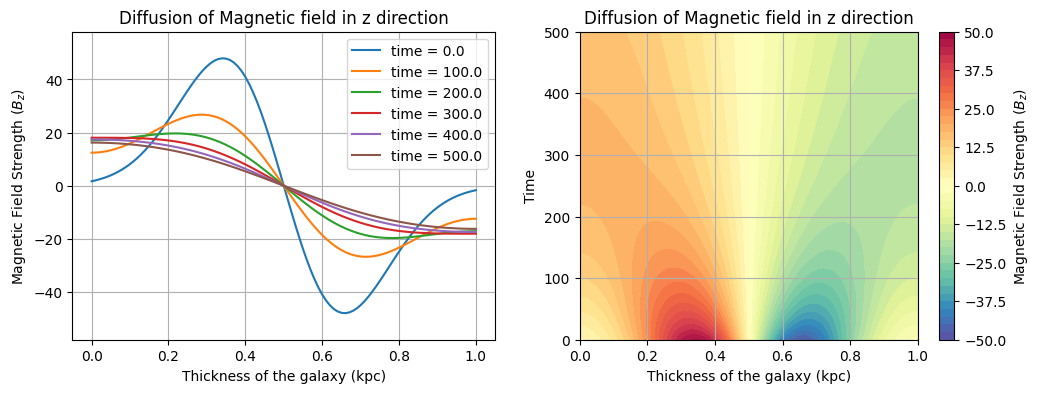

In [30]:

def init_cond(x):
    return -500*(x-0.5)*np.exp(-20*(x-0.5)**2)

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
eta_T = 1e-4    # magnetic diffusivity
t_max = 500     # total simulation time
z_max = 1.0     # thickness of the disc
dt = 0.05       # time step
dz = 0.01       # spatial step in z direction

solution, spatial_grid, time_grid = crank_nicolson_diffusion(z_max, t_max, dz, dt, eta_T, init_cond, source_term, diff_matrix_isolated_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution)

plt.show()


Now let us move to a cmopletely arbitrary type of initial magnetic field. Consider the following profile

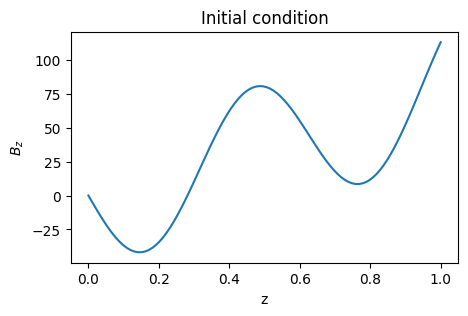

In [40]:
def init_cond(x):
    return 50*np.exp(x) - 50*np.sin(10*x) - 50

plt.figure(figsize=(5, 3))
plt.plot(np.linspace(0, 1, 100), init_cond(np.linspace(0, 1, 100)))
plt.xlabel('z')
plt.ylabel(r'$B_z$')
plt.title('Initial condition')
plt.show()

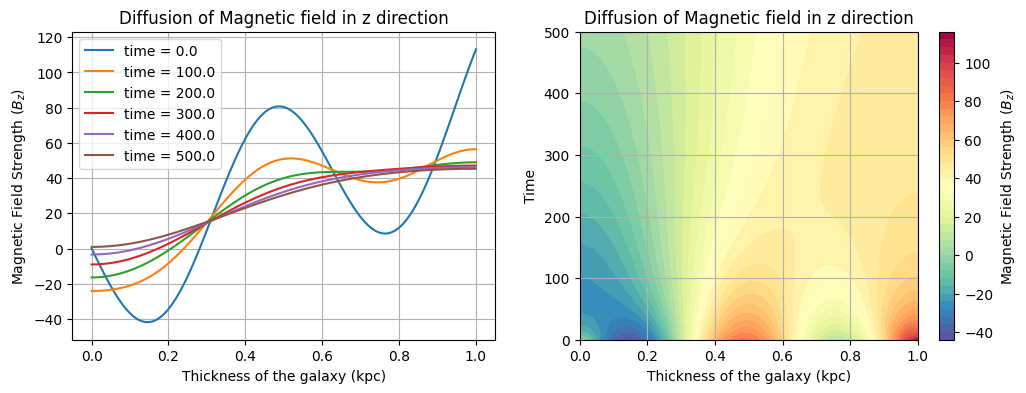

In [35]:

def init_cond(x):
    return 50*np.exp(x) - 50*np.sin(10*x) - 50

def source_term(x, t):
    return 0 # 10 * np.sin(np.pi * x) * np.exp(-0.1 * t)

# Constants and parameters
eta_T = 1e-4    # magnetic diffusivity
t_max = 500     # total simulation time
z_max = 1.0     # thickness of the disc
dt = 0.05       # time step
dz = 0.01       # spatial step in z direction

solution, spatial_grid, time_grid = crank_nicolson_diffusion(z_max, t_max, dz, dt, eta_T, init_cond, source_term, diff_matrix_isolated_boundary)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution)

plt.show()
